# Dengue
Dengue fever is a mosquito-borne illness that mostly affects tropical and subtropical regions of the world. In mild instances, symptoms are comparable to those of the flu, including fever, rash, and muscle and joint discomfort. It can cause serious bleeding, low blood pressure, and even death in extreme cases.

Dengue transmission dynamics are connected to climatic factors such as temperature and precipitation since it is spread by mosquitos. Although the link to climate is complicated, a rising number of experts suggest that climate change is likely to result in distributional alterations with important public health consequences throughout the world.

# Exploratory Data Analysis of the DengAI dataset

## Sections
1. [Data Ingestion](#Data_Ingestion)
2. [Summary Statistics](#Summary_Statistics)
3. Data Cleaning and Preprocessing
4. [Visualization](#Visualization)
5. Performing different tests {Correlation analysis, Dickey Fuller test, ADF, etc.}
6. [Conclusions](#Conclusions)

7. Experimenting with different models

## Importing required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
sns.set()

from statsmodels.tsa.seasonal import seasonal_decompose as decompose
from pandas import Series
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime as dt
from matplotlib.pyplot import figure
from statsmodels.tsa.seasonal import seasonal_decompose

***
<a id='Data_Ingestion'></a>
# 1. Data Ingestion

The study consists of data for two cities: __*San Juan, Puerto Rico*__ and __*Iquitos, , Peru*__

The dataset consists of two parts
* __dengue_features_train.csv__ : Contains readings for all the factors considered in the study (like humidity, temperature, etc.)
* __dengue_labels_train.csv__ : Contains the number of Dengue cases reported on a weekly basis.

In [2]:
env = 'VSCode'#'Colab' ### Needs to be changed...
path = '.'

if env == 'Colab':
    from google.colab import drive
    drive.mount('/content/drive')
    !ls drive/MyDrive/Dataset
    path = 'drive/MyDrive'

features = pd.read_csv(f'{path}/Dataset/dengue_features_train.csv', index_col = [0,1,2])
features.week_start_date = pd.to_datetime(features.week_start_date) # Converting the date into a date time object

cases = pd.read_csv(f'{path}/Dataset/dengue_labels_train.csv', index_col = [0,1,2])
testDf = pd.read_csv(f'{path}/Dataset/dengue_features_test.csv', index_col = [0,1,2])

# Performing an Inner Join on the dataset on the common columns
df = pd.merge(features, cases, left_index = True, right_index = True)
df.set_index(['week_start_date'], append = True, inplace = True)
df.head()

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear week_start_date                                           
sj   1990 18         1990-04-30       0.122600  0.103725  0.198483  0.177617   
          19         1990-05-07       0.169900  0.142175  0.162357  0.155486   
          20         1990-05-14       0.032250  0.172967  0.157200  0.170843   
          21         1990-05-21       0.128633  0.245067  0.227557  0.235886   
          22         1990-05-28       0.196200  0.262200  0.251200  0.247340   

                                      precipitation_amt_mm  \
city year weekofyear week_start_date                         
sj   1990 18         1990-04-30                      12.42   
          19         1990-05-07                      22.82   
          20         1990-05-14                      34.54   
          21         1990-05-21                      15.36   
          22         1990-05-28                       7.52   

                                      reanalysis_air_temp_k  \
city year weekofyear week_start_date                          
sj   1990 18         1990-04-30                  297.572857   
          19         1990-05-07                  298.211429   
          20         1990-05-14                  298.781429   
          21         1990-05-21                  298.987143   
          22         1990-05-28                  299.518571   

                                      reanalysis_avg_temp_k  \
city year weekofyear week_start_date                          
sj   1990 18         1990-04-30                  297.742857   
          19         1990-05-07                  298.442857   
          20         1990-05-14                  298.878571   
          21         1990-05-21                  299.228571   
          22         1990-05-28                  299.664286   

                                      reanalysis_dew_point_temp_k  \
city year weekofyear week_start_date                                
sj   1990 18         1990-04-30                        292.414286   
          19         1990-05-07                        293.951429   
          20         1990-05-14                        295.434286   
          21         1990-05-21                        295.310000   
          22         1990-05-28                        295.821429   

                                      reanalysis_max_air_temp_k  \
city year weekofyear week_start_date                              
sj   1990 18         1990-04-30                           299.8   
          19         1990-05-07                           300.9   
          20         1990-05-14                           300.5   
          21         1990-05-21                           301.4   
          22         1990-05-28                           301.9   

                                      reanalysis_min_air_temp_k  ...  \
city year weekofyear week_start_date                             ...   
sj   1990 18         1990-04-30                           295.9  ...   
          19         1990-05-07                           296.4  ...   
          20         1990-05-14                           297.3  ...   
          21         1990-05-21                           297.0  ...   
          22         1990-05-28                           297.5  ...   

                                      reanalysis_relative_humidity_percent  \
city year weekofyear week_start_date                                         
sj   1990 18         1990-04-30                                  73.365714   
          19         1990-05-07                                  77.368571   
          20         1990-05-14                                  82.052857   
          21         1990-05-21                                  80.337143   
          22         1990-05-28                                  80.460000   

                                      reanalysis_sat_precip_amt_mm  \
city year weekofyear week_start_date                                 
sj   1990 18 

## Counting number of rows and columns in the dataset

In [3]:
print(f"Number of attributes: {len(df.columns)}")
print(f"Number of rows {len(df)}")

Number of attributes: 21
Number of rows 1456


## We do analysis on each city independently since our literature review led us to the conclusion that the spread of Dengue varies by area.

In [4]:
sj_df = df.loc['sj']
sj_df.head()

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear week_start_date                                           
1990 18         1990-04-30       0.122600  0.103725  0.198483  0.177617   
     19         1990-05-07       0.169900  0.142175  0.162357  0.155486   
     20         1990-05-14       0.032250  0.172967  0.157200  0.170843   
     21         1990-05-21       0.128633  0.245067  0.227557  0.235886   
     22         1990-05-28       0.196200  0.262200  0.251200  0.247340   

                                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear week_start_date                                                
1990 18         1990-04-30                      12.42             297.572857   
     19         1990-05-07                      22.82             298.211429   
     20         1990-05-14                      34.54             298.781429   
     21         1990-05-21                      15.36             298.987143   
     22         1990-05-28                       7.52             299.518571   

                                 reanalysis_avg_temp_k  \
year weekofyear week_start_date                          
1990 18         1990-04-30                  297.742857   
     19         1990-05-07                  298.442857   
     20         1990-05-14                  298.878571   
     21         1990-05-21                  299.228571   
     22         1990-05-28                  299.664286   

                                 reanalysis_dew_point_temp_k  \
year weekofyear week_start_date                                
1990 18         1990-04-30                        292.414286   
     19         1990-05-07                        293.951429   
     20         1990-05-14                        295.434286   
     21         1990-05-21                        295.310000   
     22         1990-05-28                        295.821429   

                                 reanalysis_max_air_temp_k  \
year weekofyear week_start_date                              
1990 18         1990-04-30                           299.8   
     19         1990-05-07                           300.9   
     20         1990-05-14                           300.5   
     21         1990-05-21                           301.4   
     22         1990-05-28                           301.9   

                                 reanalysis_min_air_temp_k  ...  \
year weekofyear week_start_date                             ...   
1990 18         1990-04-30                           295.9  ...   
     19         1990-05-07                           296.4  ...   
     20         1990-05-14                           297.3  ...   
     21         1990-05-21                           297.0  ...   
     22         1990-05-28                           297.5  ...   

                                 reanalysis_relative_humidity_percent  \
year weekofyear week_start_date                                         
1990 18         1990-04-30                                  73.365714   
     19         1990-05-07                                  77.368571   
     20         1990-05-14                                  82.052857   
     21         1990-05-21                                  80.337143   
     22         1990-05-28                                  80.460000   

                                 reanalysis_sat_precip_amt_mm  \
year weekofyear week_start_date                                 
1990 18         1990-04-30                              12.42   
     19         1990-05-07                              22.82   
     20         1990-05-14                              34.54   
     21         1990-05-21                              15.36   
     22         1990-05-28                               7.52   

                                 reanalysis_specific_humidity_g_per_kg  \
year weekofyear week_start_date                                          
1990 18         1990-04-30                                   14.012857

In [5]:
iq_df = df.loc['iq']
iq_df.head()

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear week_start_date                                           
2000 26         2000-07-01       0.192886  0.132257  0.340886  0.247200   
     27         2000-07-08       0.216833  0.276100  0.289457  0.241657   
     28         2000-07-15       0.176757  0.173129  0.204114  0.128014   
     29         2000-07-22       0.227729  0.145429  0.254200  0.200314   
     30         2000-07-29       0.328643  0.322129  0.254371  0.361043   

                                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear week_start_date                                                
2000 26         2000-07-01                      25.41             296.740000   
     27         2000-07-08                      60.61             296.634286   
     28         2000-07-15                      55.52             296.415714   
     29         2000-07-22                       5.60             295.357143   
     30         2000-07-29                      62.76             296.432857   

                                 reanalysis_avg_temp_k  \
year weekofyear week_start_date                          
2000 26         2000-07-01                  298.450000   
     27         2000-07-08                  298.428571   
     28         2000-07-15                  297.392857   
     29         2000-07-22                  296.228571   
     30         2000-07-29                  297.635714   

                                 reanalysis_dew_point_temp_k  \
year weekofyear week_start_date                                
2000 26         2000-07-01                        295.184286   
     27         2000-07-08                        295.358571   
     28         2000-07-15                        295.622857   
     29         2000-07-22                        292.797143   
     30         2000-07-29                        293.957143   

                                 reanalysis_max_air_temp_k  \
year weekofyear week_start_date                              
2000 26         2000-07-01                           307.3   
     27         2000-07-08                           306.6   
     28         2000-07-15                           304.5   
     29         2000-07-22                           303.6   
     30         2000-07-29                           307.0   

                                 reanalysis_min_air_temp_k  ...  \
year weekofyear week_start_date                             ...   
2000 26         2000-07-01                           293.1  ...   
     27         2000-07-08                           291.1  ...   
     28         2000-07-15                           292.6  ...   
     29         2000-07-22                           288.6  ...   
     30         2000-07-29                           291.5  ...   

                                 reanalysis_relative_humidity_percent  \
year weekofyear week_start_date                                         
2000 26         2000-07-01                                  92.418571   
     27         2000-07-08                                  93.581429   
     28         2000-07-15                                  95.848571   
     29         2000-07-22                                  87.234286   
     30         2000-07-29                                  88.161429   

                                 reanalysis_sat_precip_amt_mm  \
year weekofyear week_start_date                                 
2000 26         2000-07-01                              25.41   
     27         2000-07-08                              60.61   
     28         2000-07-15                              55.52   
     29         2000-07-22                               5.60   
     30         2000-07-29                              62.76   

                                 reanalysis_specific_humidity_g_per_kg  \
year weekofyear week_start_date                                          
2000 26         2000-07-01                                   16.651429

In [6]:
datasets = {"San Juan" : sj_df, "Iquitos" : iq_df}
for city in datasets:
    print(f"Shape of {city}'s data = {datasets[city].shape}")

Shape of San Juan's data = (936, 21)
Shape of Iquitos's data = (520, 21)


***
<a id='Summary_Statistics'></a>
# 2. Summary Statistics

In [7]:
sj_df.describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,745.000000,887.000000,917.000000,917.000000,927.000000,930.000000,930.000000,930.000000,930.000000,930.000000,...,930.000000,927.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,936.000000
mean,0.057925,0.067469,0.177655,0.165956,35.470809,299.163653,299.276920,295.109519,301.398817,297.301828,...,78.568181,35.470809,16.552409,2.516267,27.006528,6.757373,31.607957,22.600645,26.785484,34.180556
std,0.107153,0.092479,0.057166,0.056073,44.606137,1.236429,1.218637,1.569943,1.258927,1.294705,...,3.389488,44.606137,1.560923,0.498892,1.415473,0.835993,1.717297,1.506277,29.325811,51.381372
min,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,295.938571,296.114286,289.642857,297.800000,292.600000,...,66.735714,0.000000,11.715714,1.357143,22.842857,4.528571,26.700000,17.800000,0.000000,0.000000
25%,0.004500,0.016425,0.139283,0.129157,0.000000,298.195000,298.300000,293.847857,300.400000,296.300000,...,76.246071,0.000000,15.236429,2.157143,25.842857,6.200000,30.600000,21.700000,6.825000,9.000000
50%,0.057700,0.068075,0.177186,0.165971,20.800000,299.254286,299.378571,295.464286,301.500000,297.500000,...,78.667857,20.800000,16.845714,2.457143,27.228571,6.757143,31.700000,22.800000,17.750000,19.000000
75%,0.111100,0.115200,0.212557,0.202771,52.180000,300.132857,300.228571,296.418929,302.400000,298.400000,...,80.963214,52.180000,17.858571,2.800000,28.185714,7.285714,32.800000,23.900000,35.450000,37.000000
max,0.493400,0.437100,0.393129,0.381420,390.600000,302.200000,302.164286,297.795714,304.300000,299.900000,...,87.575714,390.600000,19.440000,4.428571,30.071429,9.914286,35.600000,25.600000,305.900000,461.000000


In [8]:
iq_df.describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,517.000000,517.000000,517.000000,517.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,...,516.000000,516.000000,516.000000,516.000000,483.000000,483.000000,506.000000,512.000000,504.000000,520.000000
mean,0.263869,0.238783,0.250126,0.266779,64.245736,297.869538,299.133043,295.492982,307.082752,292.866667,...,88.639117,64.245736,17.096110,9.206783,27.530933,10.566197,34.004545,21.196680,62.467262,7.565385
std,0.081370,0.076751,0.077354,0.086345,35.218995,1.170997,1.332073,1.417229,2.382980,1.663069,...,7.583889,35.218995,1.445769,2.448525,0.921769,1.535496,1.325261,1.260327,63.245958,10.765478
min,0.061729,0.035860,0.029880,0.064183,0.000000,294.635714,294.892857,290.088571,300.000000,286.900000,...,57.787143,0.000000,12.111429,3.714286,21.400000,5.200000,30.100000,14.700000,0.000000,0.000000
25%,0.200000,0.179540,0.194743,0.204129,39.105000,297.092500,298.221429,294.593929,305.200000,291.975000,...,84.295000,39.105000,16.102857,7.371429,27.000000,9.500000,33.200000,20.600000,17.200000,1.000000
50%,0.263643,0.232971,0.249800,0.262143,60.470000,297.822857,299.121429,295.852143,307.050000,293.050000,...,90.917143,60.470000,17.428571,8.964286,27.600000,10.625000,34.000000,21.300000,45.300000,5.000000
75%,0.319971,0.293929,0.302300,0.325150,85.757500,298.649286,300.123214,296.548571,308.700000,294.200000,...,94.563929,85.757500,18.180357,11.014286,28.100000,11.655000,34.900000,22.000000,85.950000,9.000000
max,0.508357,0.454429,0.538314,0.546017,210.830000,301.637143,302.928571,298.450000,314.000000,296.000000,...,98.610000,210.830000,20.461429,16.028571,30.800000,15.800000,42.200000,24.200000,543.300000,116.000000


## 2.1 Missing Data

In [9]:
for city in datasets:
    print(city)
    nullVals = datasets[city].isnull()
    nullValCounts = nullVals.sum()
    print(dict(nullValCounts))
    print(f"\nFraction of data missing per column:\n{dict(nullValCounts / len(datasets[city]))}\n")
    print(f"Total Missing data = {nullValCounts.sum()}")
    print(f"Total Duplicated data = {datasets[city].duplicated().sum()}")
    print(f"Total Incomplete data = {nullVals.any(axis = 1).sum()}")
    print("------------------------------------------\n")

San Juan
{'ndvi_ne': 191, 'ndvi_nw': 49, 'ndvi_se': 19, 'ndvi_sw': 19, 'precipitation_amt_mm': 9, 'reanalysis_air_temp_k': 6, 'reanalysis_avg_temp_k': 6, 'reanalysis_dew_point_temp_k': 6, 'reanalysis_max_air_temp_k': 6, 'reanalysis_min_air_temp_k': 6, 'reanalysis_precip_amt_kg_per_m2': 6, 'reanalysis_relative_humidity_percent': 6, 'reanalysis_sat_precip_amt_mm': 9, 'reanalysis_specific_humidity_g_per_kg': 6, 'reanalysis_tdtr_k': 6, 'station_avg_temp_c': 6, 'station_diur_temp_rng_c': 6, 'station_max_temp_c': 6, 'station_min_temp_c': 6, 'station_precip_mm': 6, 'total_cases': 0}

Fraction of data missing per column:
{'ndvi_ne': 0.20405982905982906, 'ndvi_nw': 0.05235042735042735, 'ndvi_se': 0.0202991452991453, 'ndvi_sw': 0.0202991452991453, 'precipitation_amt_mm': 0.009615384615384616, 'reanalysis_air_temp_k': 0.00641025641025641, 'reanalysis_avg_temp_k': 0.00641025641025641, 'reanalysis_dew_point_temp_k': 0.00641025641025641, 'reanalysis_max_air_temp_k': 0.00641025641025641, 'reanalysis_

### There are quite a few missing entries in the dataset. It is not ideal to drop these rows. We propose multiple ways of imputing the data in the model section.

## 2.2 Outliers
Box-Plots to visualize outliers in the number of cases for both the cities

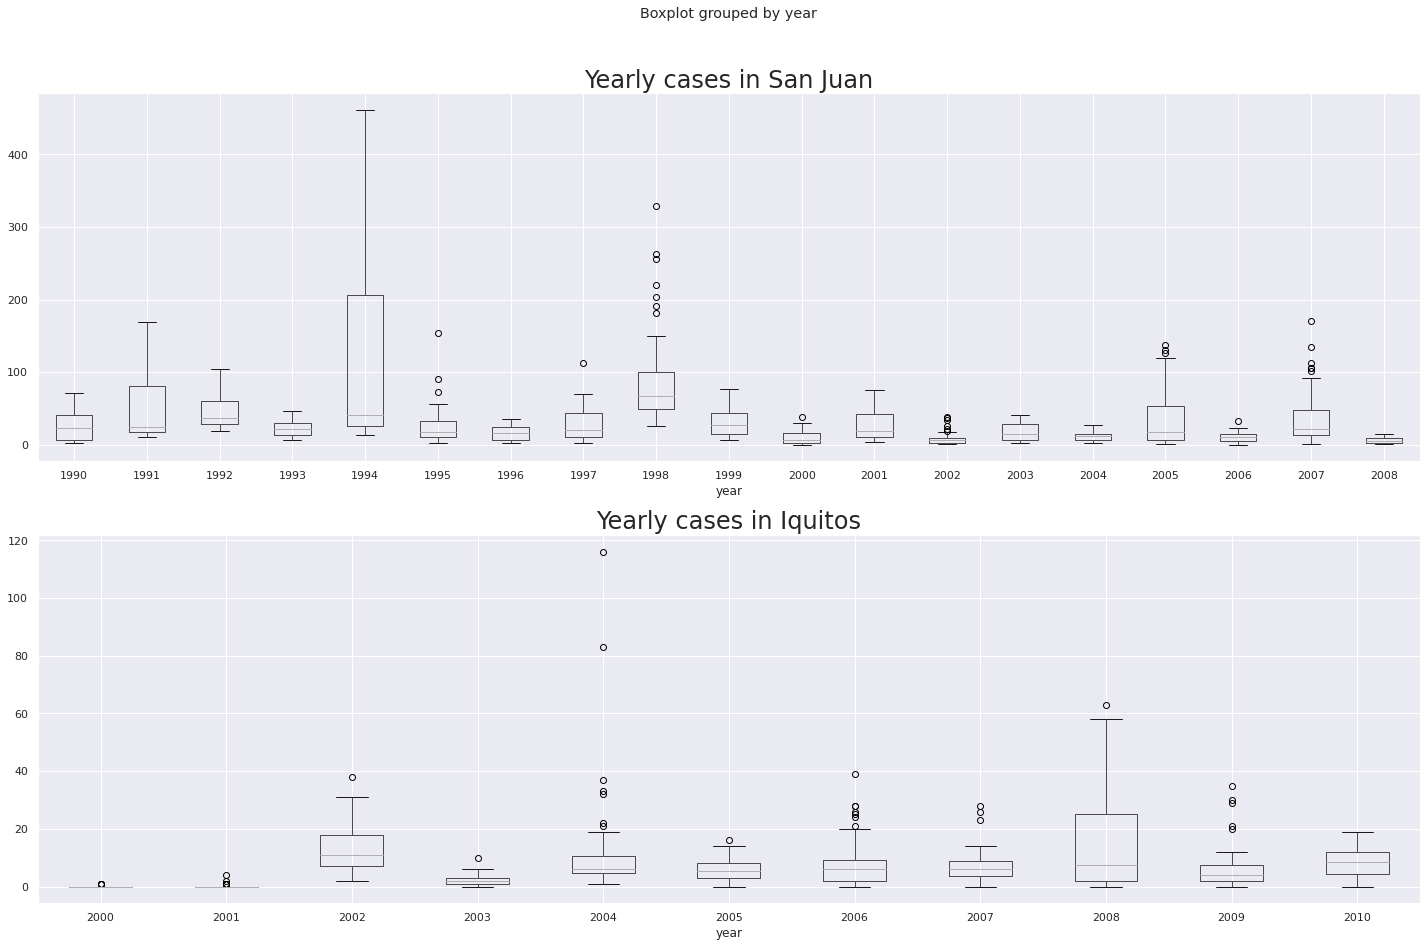

In [10]:
# Box plot for every year
plt.rcParams["figure.figsize"] = 24, 15
fig, axs = plt.subplots(2, 1)

# Number of cases every year
sj_df.boxplot(by = 'year', column = ['total_cases'], ax = axs[0])
axs[0].set_title("Yearly cases in San Juan", size = 24)

iq_df.boxplot(by = "year", column = ["total_cases"], ax = axs[1])
axs[1].set_title("Yearly cases in Iquitos", size = 24)


plt.show()

***
<a id='Visualization'></a>
# 4. Visualization

## 4.1 Line Plots

### 4.1.1 Line plot to vizualize `Number of cases vs time`, `Humidity vs time` and `temperature vs time`

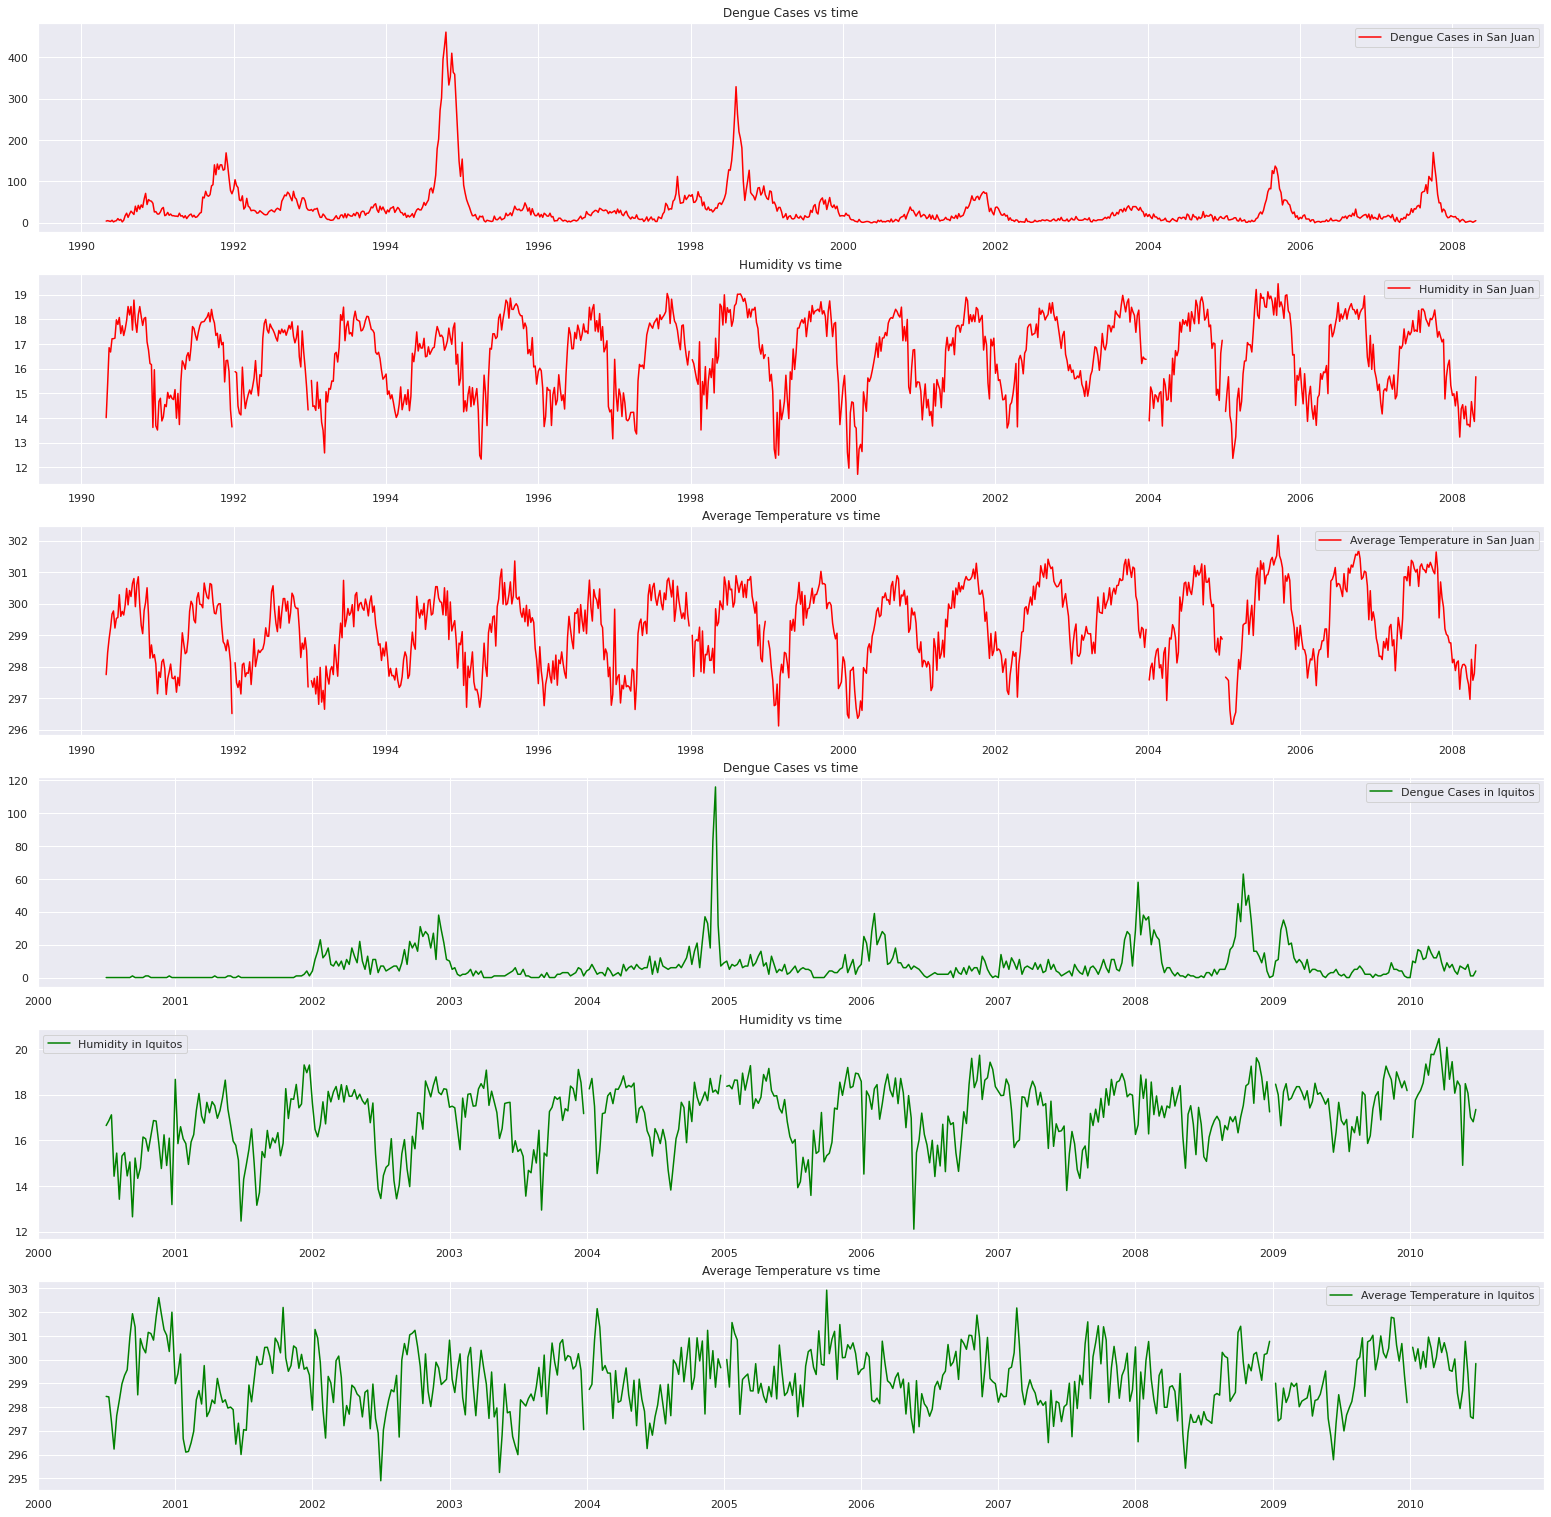

In [11]:
all_concerns = [
  'total_cases',
  'reanalysis_specific_humidity_g_per_kg',
  'reanalysis_avg_temp_k'
]

labels = [
  'Dengue Cases',
  'Humidity',
  'Average Temperature'
]

colors = ["red", "green"]

plt.rcParams['figure.figsize'] = (27, 27) # rc -> runtime config
fig,ax = plt.subplots(len(all_concerns) * len(datasets), 1) 

for index, city in enumerate(datasets):
  for i,concern in enumerate(all_concerns):
    ax[i + index*len(all_concerns)].plot(
        datasets[city].index.get_level_values(2),
        datasets[city][concern],
        color = colors[0 + index],
        label = f"{labels[i]} in {city}"
    )
    ax[i + index*len(all_concerns)].set_title(f"{labels[i]} vs time")
    ax[i + index*len(all_concerns)].legend()

plt.show()

### 4.1.2 Finding the number of yearly cases in both cities

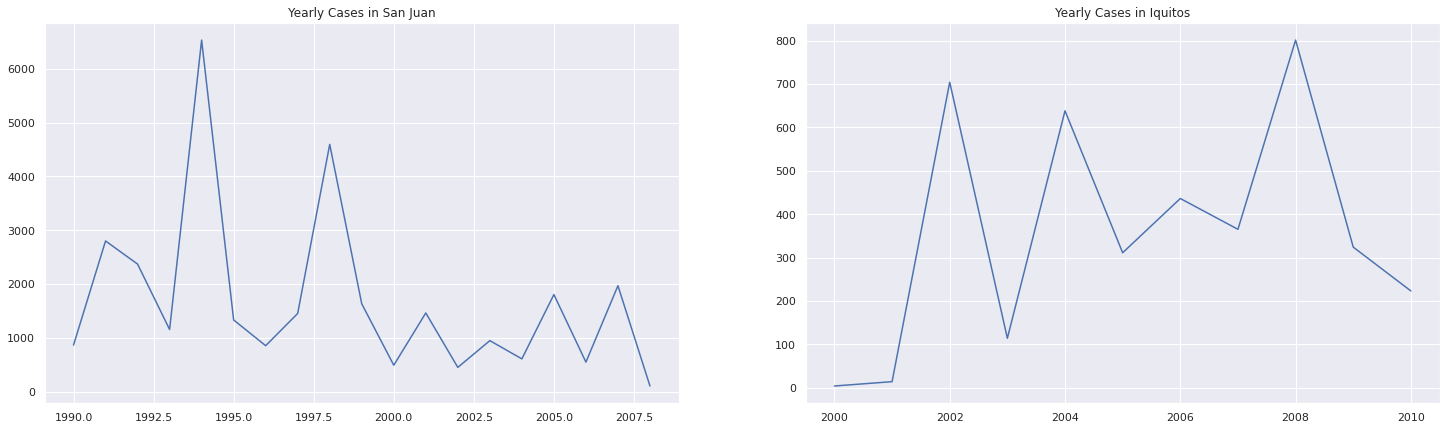

In [12]:
sj_df_yearly = pd.DataFrame(
    {
        "year" : np.unique(sj_df.index.get_level_values(0)),
        "total_cases" : sj_df.groupby(["year"])["total_cases"].sum()
    }
)

iq_df_yearly = pd.DataFrame(
    {
        "year" : np.unique(iq_df.index.get_level_values(0)),
        "total_cases" : iq_df.groupby(["year"])["total_cases"].sum()
    }
)

plt.rcParams['figure.figsize'] = (25, 7) #rc -> runtime config
fig, axs = plt.subplots(1, 2) 

axs[0].plot(sj_df_yearly.year, sj_df_yearly.total_cases)
axs[0].set_title("Yearly Cases in San Juan")

axs[1].plot(iq_df_yearly.year, iq_df_yearly.total_cases)
axs[1].set_title("Yearly Cases in Iquitos")

plt.show()

## 4.2 Histograms
Understanding the distribution of data for `total number of cases, specific humidity and air temperature in both cities`

**TODO FOR ALL IMPORTANT FEATURES**

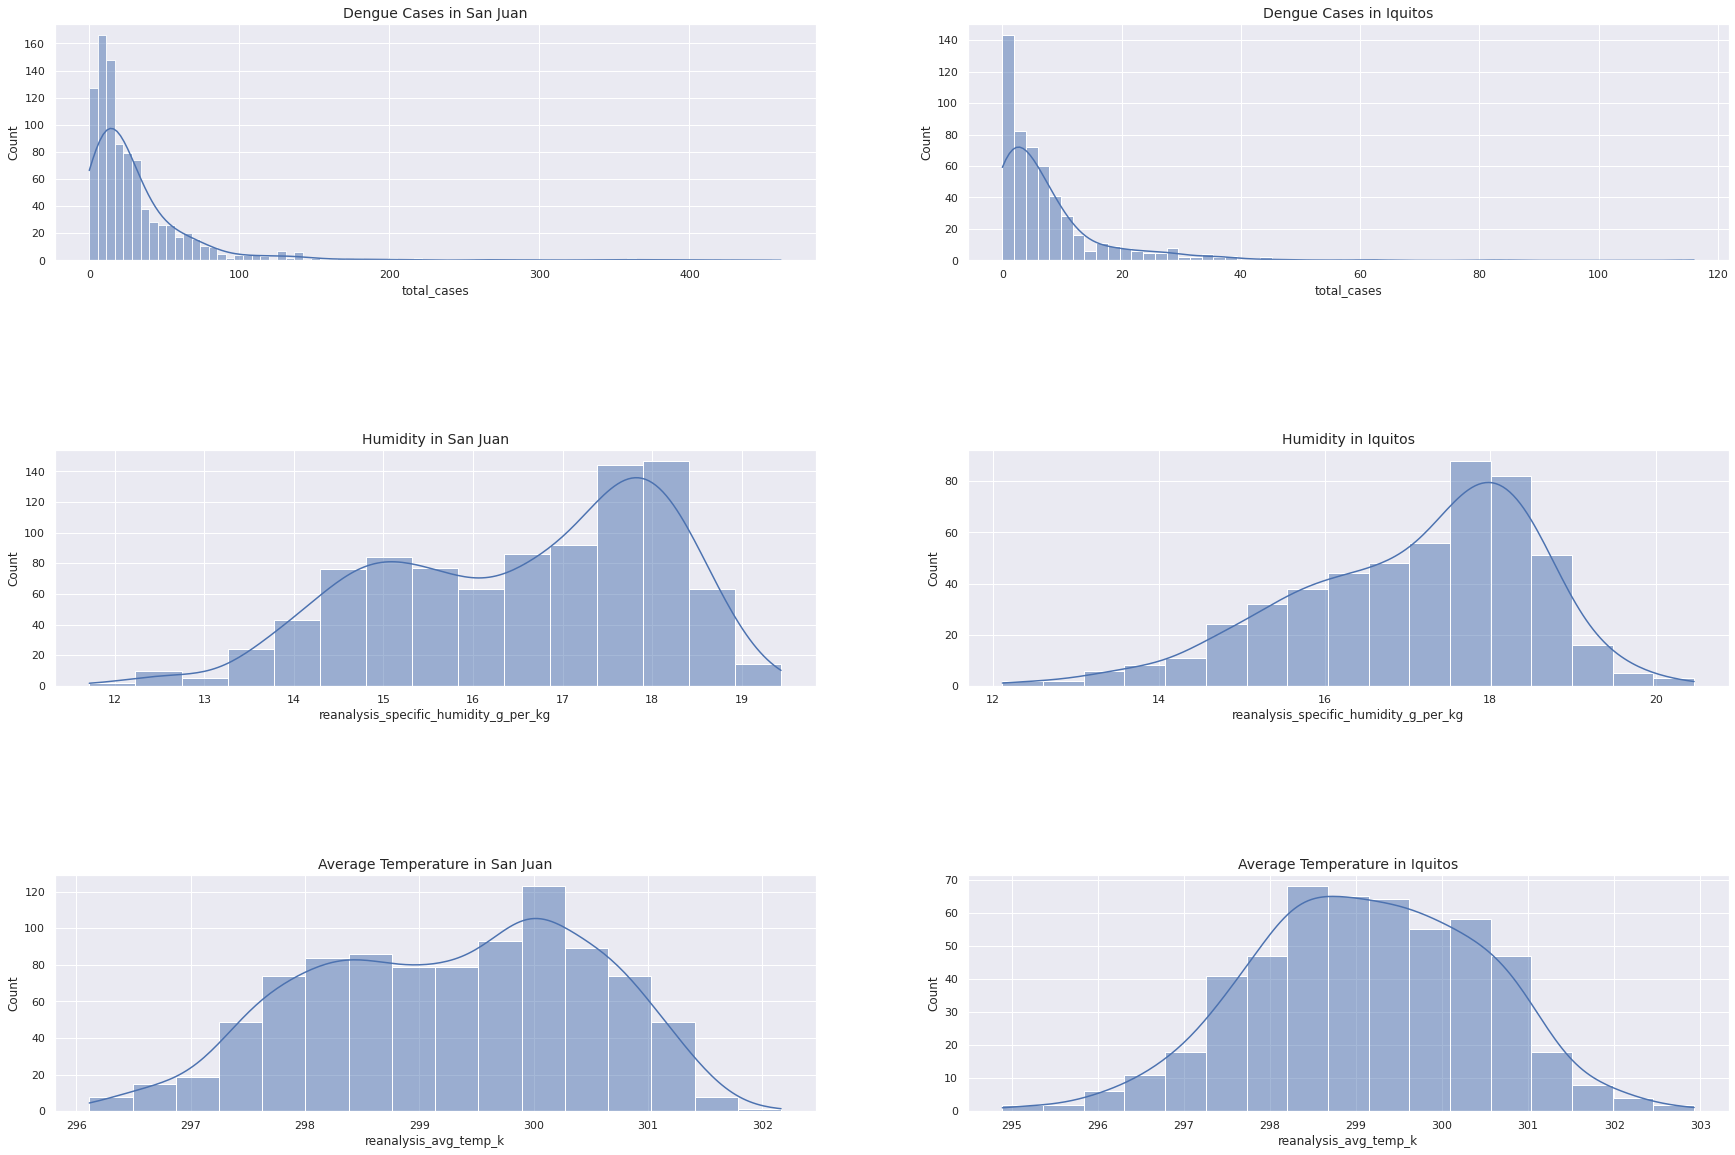

In [13]:
all_concerns = [
  'total_cases',
  'reanalysis_specific_humidity_g_per_kg',
  'reanalysis_avg_temp_k'
]

labels = [
  'Dengue Cases',
  'Humidity',
  'Average Temperature'
]

plt.rcParams["figure.figsize"] = 30, 20
fig, axs = plt.subplots(len(all_concerns), len(datasets)) 
plt.subplots_adjust(hspace = 0.8) #space between plots

for index, city in enumerate(datasets):
    for i,concern in enumerate(all_concerns):
        sns.histplot(datasets[city][concern], ax = axs[i, index], kde = True)
        axs[i, index].set_title(f"{labels[i]} in {city}",size=14)
        

plt.show()

### Inferences
The Dengue cases in San Juan and Iquitos are both right skewed.

Standard regression techniques for predicting non negative integers (number of dengue cases over here) include:
* Poisson Regression: Assumes that the mean and variance of the population distribution are equal (not the case we see here).
* Negative Binomial Regression: Allows for a larger class of possible models (no assumptions about mean and variance). In fact, a Poisson distribution is but a special case of the negative binomial distribution.

Here, variance >> mean suggesting that the total_cases can be described by a negative binomial distribution.
We use a negative binomial regression below as a baseline for comparison.

Humidity is almost right left skewed while the average temperature are subbotin distribution due to the plateu in between.

## 4.3 Bar Plots

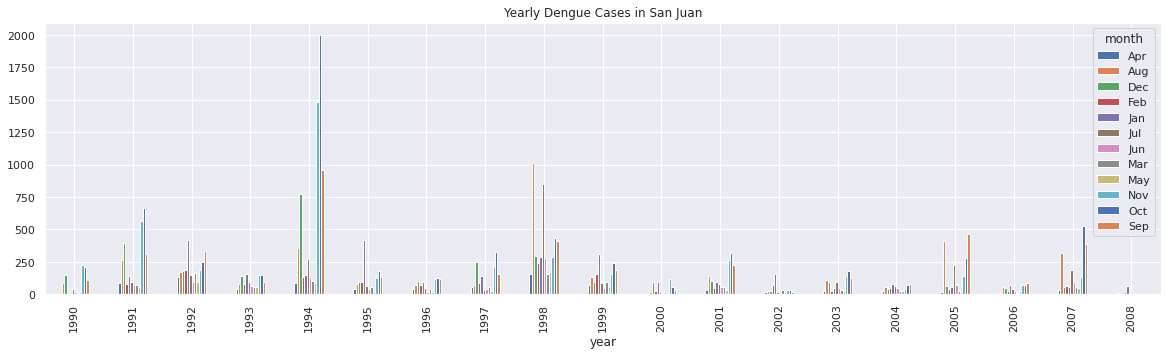

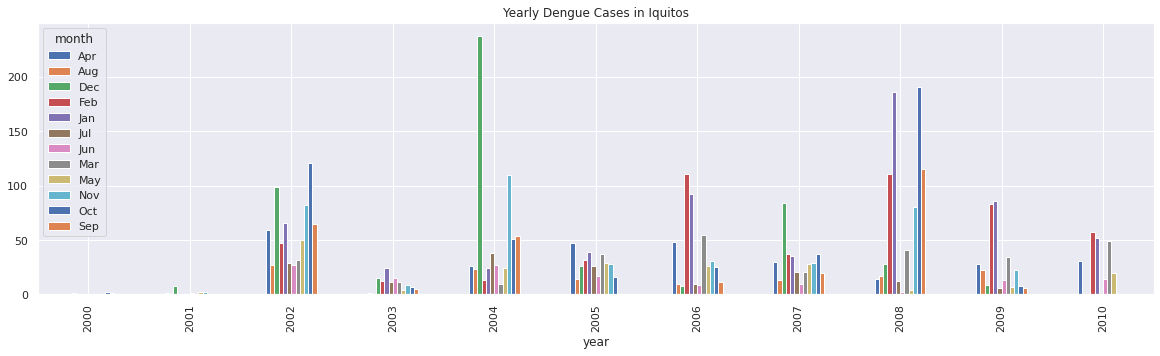

In [14]:
for city in datasets:
    datasets[city].insert(loc = len(datasets[city].columns), column = 'month', value = datasets[city].index.get_level_values(2).strftime("%b"))
    year_monthly = datasets[city].groupby(['year','month']).sum('total_cases')
    year_monthly.unstack('month')['total_cases']\
        .plot(
            kind = "bar", 
            figsize = (20, 5),
            title = f"Yearly Dengue Cases in {city}"
        )

    plt.show()

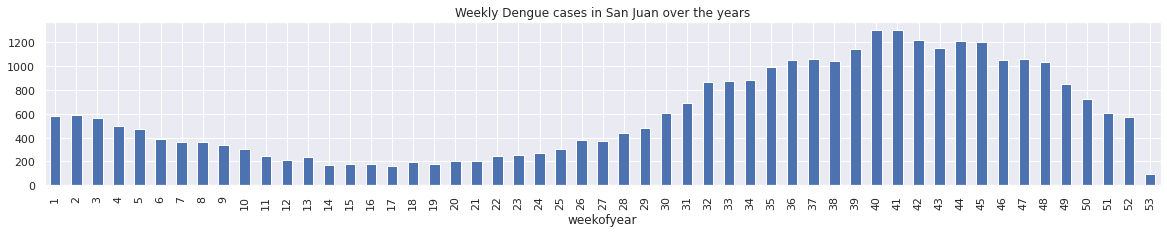

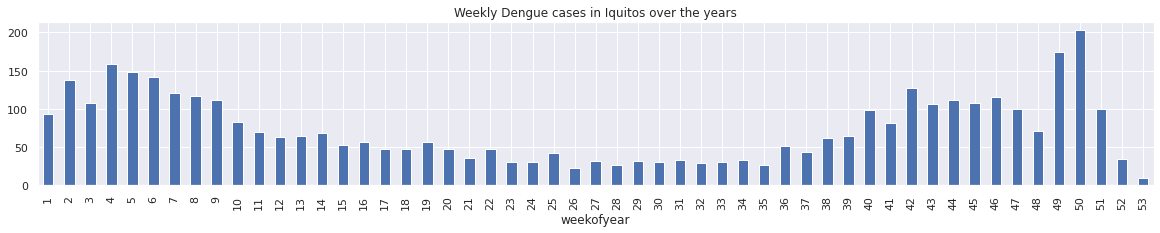

In [15]:
for city in datasets:
        datasets[city].groupby(['weekofyear'])\
        .sum('total_cases')\
        .unstack('weekofyear')['total_cases']\
        .plot(
            kind = "bar",
            figsize = (20,3),
            title = f"Weekly Dengue cases in {city} over the years"
        )
        plt.show()

## 4.4 Correlation matrices

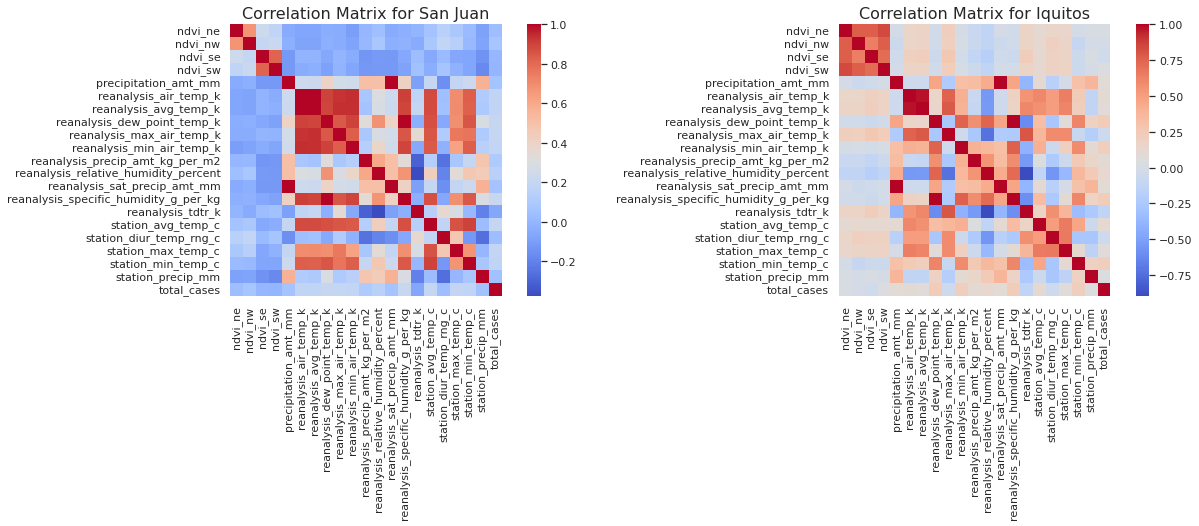

In [16]:
f, ax = plt.subplots(ncols = 2, figsize=(20, 5))
correlations = {city: None for city in datasets}
for index, city in enumerate(datasets):
        correlations[city] = datasets[city].corr()
        sns.heatmap(correlations[city], square = True, cmap = 'coolwarm', ax = ax[index])
        ax[index].set_title(f'Correlation Matrix for {city}', fontsize = 16)

plt.show()

### Inferences
Many of the temperature data are strongly correlated, which is expected. But the total_cases variable doesn't have many obvious strong correlations.
Interestingly, total_cases seems to only have weak correlations with other variables. Many of the climate variables are much more strongly correlated. Interestingly, the vegetation index also only has weak correlation with other variables. 

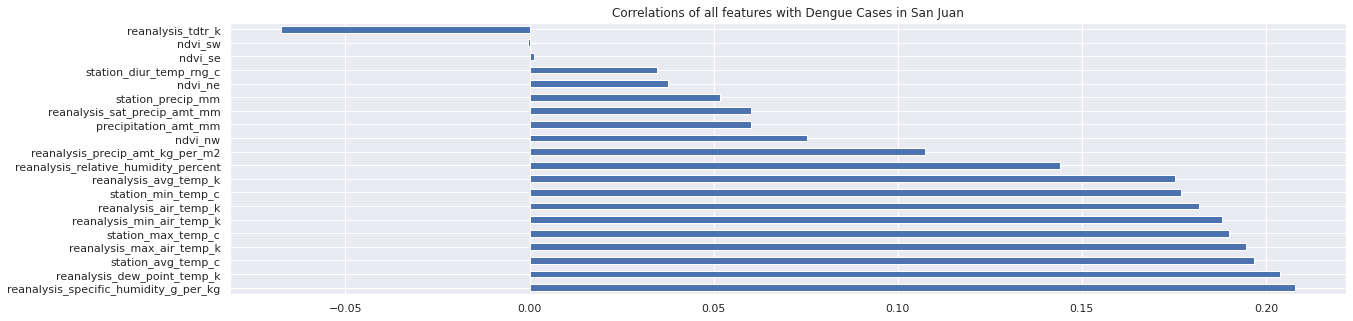

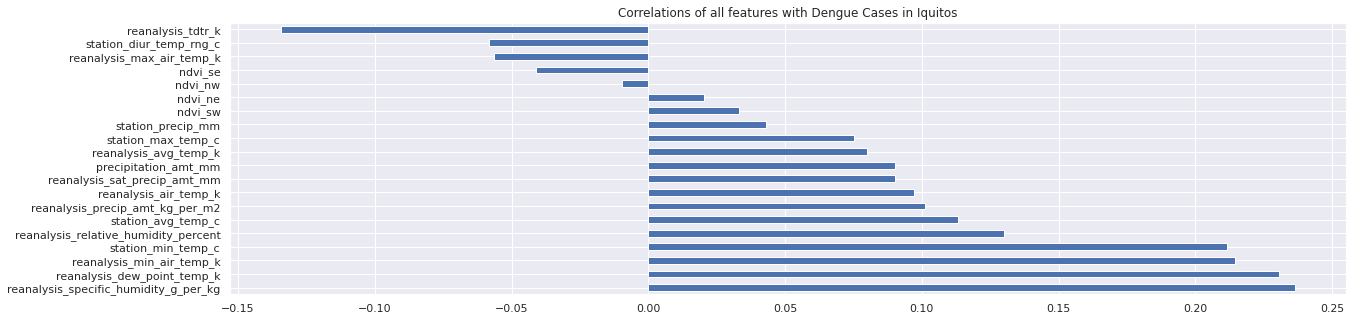

In [17]:
for city in datasets:
     (correlations[city]
          .total_cases
          .drop('total_cases') # Prevent comparing total_cases with itself
          .sort_values(ascending=False)
          .plot
          .barh(figsize = (20, 5), title = f"Correlations of all features with Dengue Cases in {city}"))
     plt.show()

### Inferences
* The correlation strengths differ for each city, but it looks like reanalysis_specific_humidity_g_per_kg and reanalysis_dew_point_temp_k are the most strongly correlated with total_cases. This makes sense: we know mosquitos thrive in wet climates.
* As we all know, "cold and humid" is not a thing. So it's not surprising that as minimum temperatures, maximum temperatures, and average temperatures rise, the total_cases of dengue fever tend to rise as well.
* Interestingly, the precipitation measurements bear little to no correlation to total_cases, despite strong correlations to the humidity measurements, as evident by the heatmaps above.

***
<a id='Conclusions'></a>
# 6. Conclusions

- How many rows and attributes?
    - San Juan: `(936, 25)`.
    - Iquitos : `(520, 25)`.
- How many missing data and outliers?
    - San Juan: `380 Missing`.
    - Iquitos : `168 Missing`.
- Any inconsistent, incomplete, duplicate or incorrect data?
    - All records in both the datasets are unique.
    - Number of incomplete rows in San Juan's data: `209`.
    - Number of incomplete rows in Iquitos's data : `48`.
- Are the variables correlated to each other?
    - San Juan: ``.
    - Iquitos : ``.

- Are any of the preprocessing techniques needed: rolling average, continuum cubic spline curve, dimensionality reduction, range transformation, standardization, etc.?
    - San Juan: ``.
    - Iquitos : ``.
    
- Does PCA help visualize the data? Do we get any insights from histograms/bar charts/line plots, etc.?

In [18]:
# def imputeMissing(dfs):
#     for adf in dfs:
#         for col in adf.columns[adf.isna().any()].tolist():
#             adf[col].interpolate(method="time",inplace=True) # Why inplace?
#     return iq_df,sj_df

# iq_df_imputed, sj_df_imputed = imputeMissing([iq_df,sj_df])

In [19]:
sj_df_imputed = sj_df
iq_df_imputed = iq_df

In [20]:
# def pcaAnalysis(dfs_list,num_components): #work on the imputed data
#     dfs,original_dfs = dfs_list

#     details = {
#         0:['iq','red'],
#         1:['sj','blue']
#     }

#     sc = StandardScaler()
#     pca = PCA()
#     res = []
    
#     #number of components to keep can be explained with the help of 
#     #explained variance ratio as a function of the number of components
#     #it is the percentage of variance attributed to each of the selected component
#     #hence we shld go on adding components until the total variance ratio is upto 80% or so to avoid overfitting

#     for df_indx,adf in enumerate(dfs):
#         adf = adf.drop(['city', 'month'], axis = 1, errors = 'ignore')
        
#         #convert datetime to ordinal value from datetime object for normalization
#         adf['week_start_date'] = adf['week_start_date'].map(dt.datetime.toordinal)
#         adf = sc.fit_transform(adf)
#         adf_pca = pca.fit(adf)
        
#         plt.plot(
#             np.cumsum(pca.explained_variance_ratio_),
#             label = details[df_indx][0],
#             color = details[df_indx][1],
#         )

#         pca = PCA(num_components)
#         adf_pca = pca.fit_transform(adf)

#         #get the most important features
#         #pca.components_ is a list of eigenvector magnitudes for each priciple component
#         most_imp = [np.abs(pca.components_[i]).argmax() for i in range(pca.n_components_)]
#         most_imp_names = [original_dfs[df_indx].columns[most_imp[i]] for i in range(pca.n_components_)]
#         res.append(most_imp_names)

#     plt.xlabel("number of components")
#     plt.ylabel('cumulative explained variance')
#     plt.legend()
#     plt.plot()
#     return res

# important_columns = pcaAnalysis([[iq_df_imputed,sj_df_imputed],[iq_df,sj_df]],15)

In [21]:
def getCorrelationAtWeeksLag(df,max_lag):
    target = 'total_cases'
    df = df.drop(['city','year','week_start_date','weekofyear', 'month'], axis = 1, errors = 'ignore')
    lagged_correlation = pd.DataFrame.from_dict(
    {x: [df[target].corr(df[x].shift(-t)) for t in range(max_lag+1)] for x in df.columns})
    return lagged_correlation,max_lag


lagged_correlation,max_lag = getCorrelationAtWeeksLag(iq_df,28)

In [22]:
lagged_correlation

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,0.020215,-0.009586,-0.041067,0.032999,0.090171,0.097098,0.079872,0.230401,-0.056474,0.214514,...,0.130083,0.090171,0.236476,-0.134425,0.113070,-0.058230,0.075279,0.211702,0.042976,1.000000
1,-0.009168,-0.039067,-0.051372,-0.022564,0.126373,0.085000,0.075206,0.273373,-0.068650,0.220423,...,0.173361,0.126373,0.281422,-0.151738,0.104491,-0.083870,0.044866,0.211372,0.092943,0.747084
2,-0.038249,-0.046124,-0.055068,-0.046349,0.138933,0.071128,0.065623,0.279001,-0.084059,0.234006,...,0.188705,0.138933,0.287449,-0.168349,0.116281,-0.085066,0.007521,0.215103,0.048573,0.584954
3,0.015518,-0.009272,-0.027174,-0.000302,0.154116,0.052247,0.044193,0.317006,-0.129125,0.239650,...,0.233089,0.154116,0.324496,-0.207124,0.067233,-0.142286,-0.034814,0.227285,0.093774,0.546021
4,-0.030485,-0.067498,-0.049213,-0.044691,0.110797,0.048775,0.055327,0.282834,-0.108470,0.212660,...,0.207474,0.110797,0.289870,-0.173806,0.076058,-0.128174,-0.042635,0.206264,0.060848,0.489673
5,-0.028446,-0.017104,-0.044352,-0.044913,0.125181,0.010892,0.012585,0.287336,-0.142192,0.190697,...,0.234556,0.125181,0.294331,-0.214112,0.066779,-0.160785,-0.076981,0.229438,0.097302,0.365825
6,-0.041623,-0.017155,-0.059567,-0.063969,0.147167,0.028809,0.024320,0.270012,-0.138851,0.190610,...,0.205492,0.147167,0.275893,-0.187257,0.071332,-0.136668,-0.068738,0.215851,0.129452,0.285352
7,-0.058939,-0.033729,-0.072778,-0.083336,0.085792,0.031832,0.026183,0.233563,-0.151812,0.184629,...,0.172736,0.085792,0.240502,-0.162972,0.056213,-0.120289,-0.076694,0.193776,0.044406,0.262240
8,-0.120442,-0.095808,-0.126150,-0.151810,0.116093,0.005989,0.002673,0.225736,-0.153482,0.183930,...,0.183687,0.116093,0.230611,-0.184025,0.040014,-0.160164,-0.084790,0.191917,0.011315,0.205341
9,-0.161217,-0.120204,-0.135698,-0.185118,0.097568,-0.056699,-0.060903,0.205867,-0.204316,0.149723,...,0.208393,0.097568,0.207519,-0.212088,-0.008266,-0.207656,-0.131638,0.167248,0.060809,0.153588


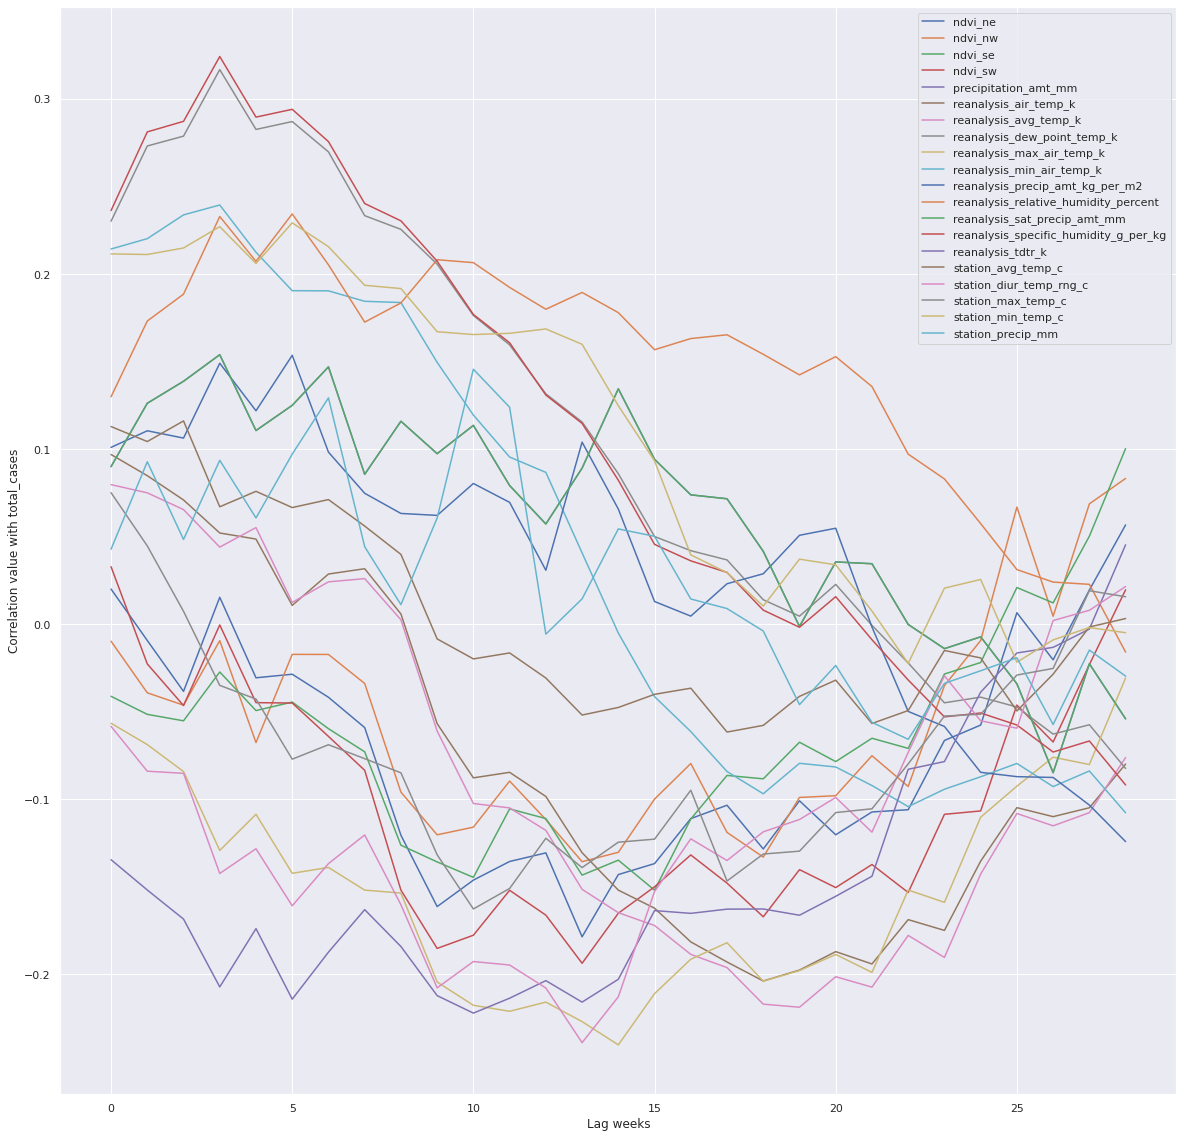

In [23]:
def plotCorrelationAtLags(lagged_correlation,max_lag):
    plt.rcParams["figure.figsize"] = (20,20) # Make bar graph instead
 
    for col in lagged_correlation.columns:
        if col!='total_cases':
            y= lagged_correlation[col]
            x = range(0,max_lag+1)
            plt.plot(x,y,label=f'{col}')
            plt.legend()
            plt.xlabel("Lag weeks")
            plt.ylabel("Correlation value with total_cases")
    plt.show()

plotCorrelationAtLags(lagged_correlation,max_lag)

Seasonality Decomposition 

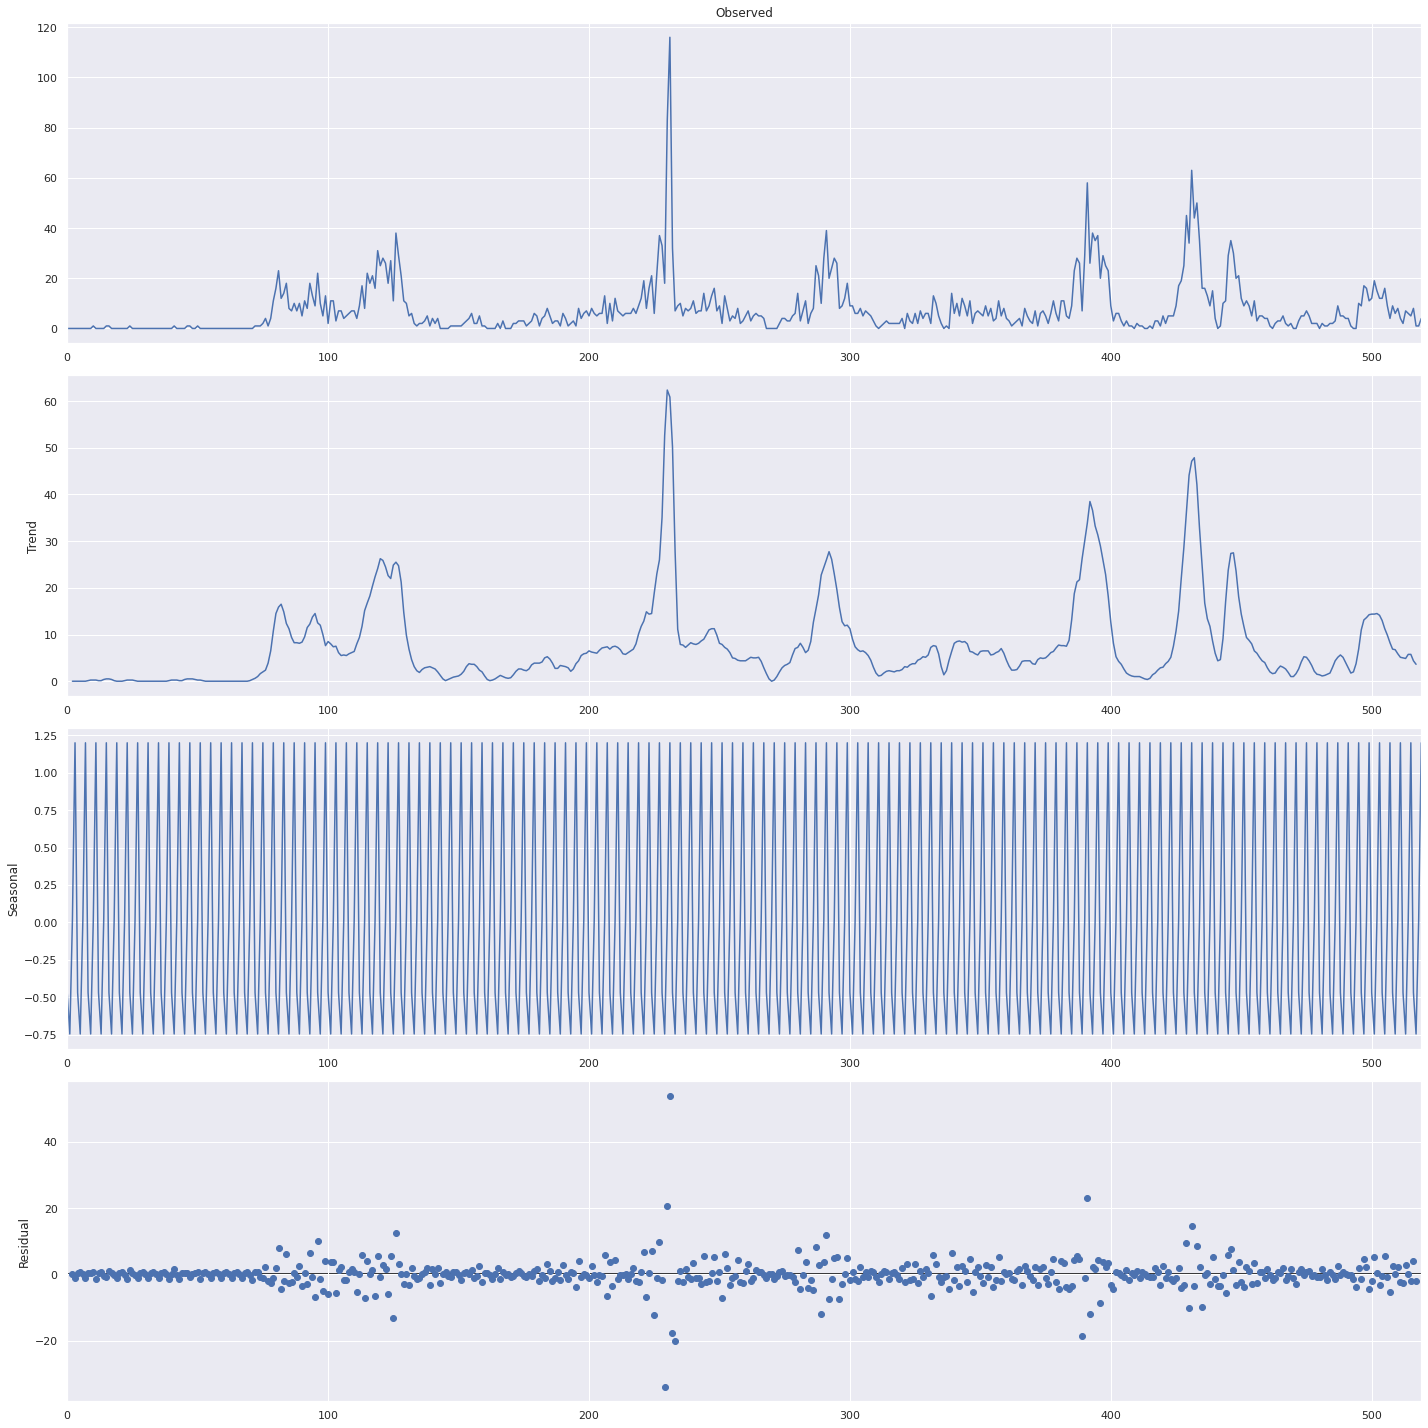

In [24]:
res = seasonal_decompose(iq_df_imputed['total_cases'].values, model="additive", period=4)
res.plot()
plt.show()

Inference 
->Trend : slightly increasing trend
-> Has seasonality

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from xgboost import XGBRegressor, plot_importance

from sklearn.experimental import enable_iterative_imputer  # noqa

from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

## Negative Binomial Regression

In [26]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf
import statsmodels.api as sm

def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "station_avg_temp_c"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('Best alpha = ', best_alpha)
    print('MAE = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

In [27]:
sjDfBin = sj_df_imputed.fillna(method='ffill')
iqDfBin = iq_df_imputed.fillna(method='ffill')

sjPart = 800
sj_train_subtrain = sjDfBin.head(sjPart)
sj_train_subtest = sjDfBin.tail(sjDfBin.shape[0] - sjPart)

iqPart = 400
iq_train_subtrain = iqDfBin.head(iqPart)
iq_train_subtest = iqDfBin.tail(iqDfBin.shape[0] - iqPart)

sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

Best alpha =  1e-08
MAE =  22.080882352941178
Best alpha =  1e-08
MAE =  6.466666666666667


## XGBoost

In [28]:
trainDfiq = iq_df_imputed
trainDfsj = sj_df_imputed

In [29]:
def train(df, part):
    unwantedCols = ['month', 'week_start_date', 'year', 'weekofyear', 'week_start_date', 'city', 'total_cases']

    trainDf = df.head(part)
    valDf = df.tail(df.shape[0] - part)


    x = trainDf.drop(unwantedCols, axis = 1, errors = 'ignore')
    y = trainDf['total_cases']

    # Parameters for Grid Search
    param_grid = dict(
        # imputer = []
        preprocessor = [MinMaxScaler(), RobustScaler(), StandardScaler()]
    )

    xgbModel = XGBRegressor(
        # booster = 'gblinear',
        # objective ='reg:squarederror',
        random_state = 1, 
        n_estimators = 500, 
        learning_rate = 0.1
    )

    xgbPipeline = Pipeline(
        steps = [
            ('imputer',  KNNImputer(missing_values=np.nan)),
            ('preprocessor', RobustScaler()),
            ('model', xgbModel)
        ]
    )

    grid = GridSearchCV(xgbPipeline, param_grid = param_grid, cv = 4, verbose = 3)
    grid.fit(x, y)
    print("\nBest Model:")
    print(grid.best_estimator_)

    xgbPipeline = grid.best_estimator_

    predictions = xgbPipeline.predict(valDf.drop(unwantedCols, axis = 1, errors = 'ignore')).astype(int)
    score = eval_measures.meanabs(predictions, valDf.total_cases)
    print(f"MAE = {score}")

    xgbPipeline.steps[-1][1].get_booster().feature_names = list(x.columns)
    plot_importance(xgbPipeline.steps[-1][1].get_booster())
    plt.show()

    return xgbPipeline


Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4] END ......preprocessor=MinMaxScaler();, score=-1.478 total time=   3.1s
[CV 2/4] END ......preprocessor=MinMaxScaler();, score=-0.138 total time=   3.4s
[CV 3/4] END ......preprocessor=MinMaxScaler();, score=-0.134 total time=   3.6s
[CV 4/4] END ......preprocessor=MinMaxScaler();, score=-4.935 total time=   3.8s
[CV 1/4] END ......preprocessor=RobustScaler();, score=-1.479 total time=   3.2s
[CV 2/4] END ......preprocessor=RobustScaler();, score=-0.138 total time=   4.0s
[CV 3/4] END ......preprocessor=RobustScaler();, score=-0.134 total time=   4.0s
[CV 4/4] END ......preprocessor=RobustScaler();, score=-4.937 total time=   3.0s
[CV 1/4] END ....preprocessor=StandardScaler();, score=-1.489 total time=   2.2s
[CV 2/4] END ....preprocessor=StandardScaler();, score=-0.138 total time=   3.1s
[CV 3/4] END ....preprocessor=StandardScaler();, score=-0.134 total time=   2.6s
[CV 4/4] END ....preprocessor=StandardScaler();, 

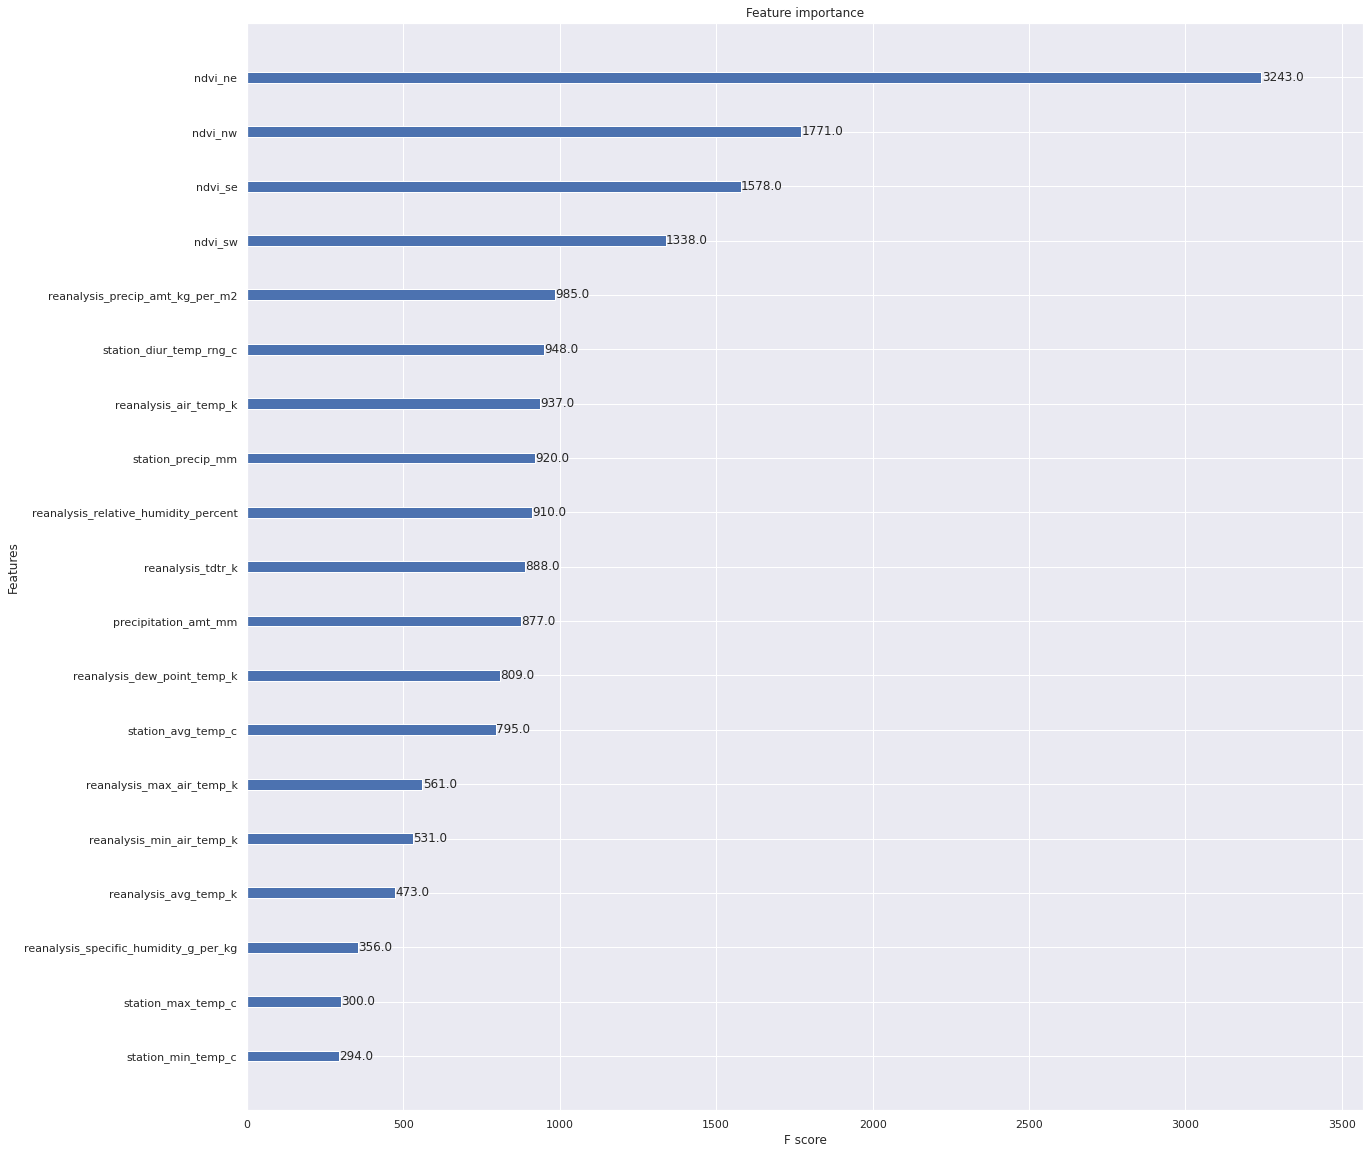

In [30]:
sjModel = train(sj_df_imputed, sjPart)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4] END ......preprocessor=MinMaxScaler();, score=-1.345 total time=   1.9s
[CV 2/4] END ......preprocessor=MinMaxScaler();, score=-1.084 total time=   1.8s
[CV 3/4] END ......preprocessor=MinMaxScaler();, score=-0.098 total time=   2.8s
[CV 4/4] END ......preprocessor=MinMaxScaler();, score=-0.461 total time=   0.7s
[CV 1/4] END ......preprocessor=RobustScaler();, score=-1.364 total time=   0.9s
[CV 2/4] END ......preprocessor=RobustScaler();, score=-1.090 total time=   4.3s
[CV 3/4] END ......preprocessor=RobustScaler();, score=-0.095 total time=   1.4s
[CV 4/4] END ......preprocessor=RobustScaler();, score=-0.460 total time=   1.6s
[CV 1/4] END ....preprocessor=StandardScaler();, score=-1.364 total time=   1.0s
[CV 2/4] END ....preprocessor=StandardScaler();, score=-1.085 total time=   0.8s
[CV 3/4] END ....preprocessor=StandardScaler();, score=-0.095 total time=   0.8s
[CV 4/4] END ....preprocessor=StandardScaler();, 

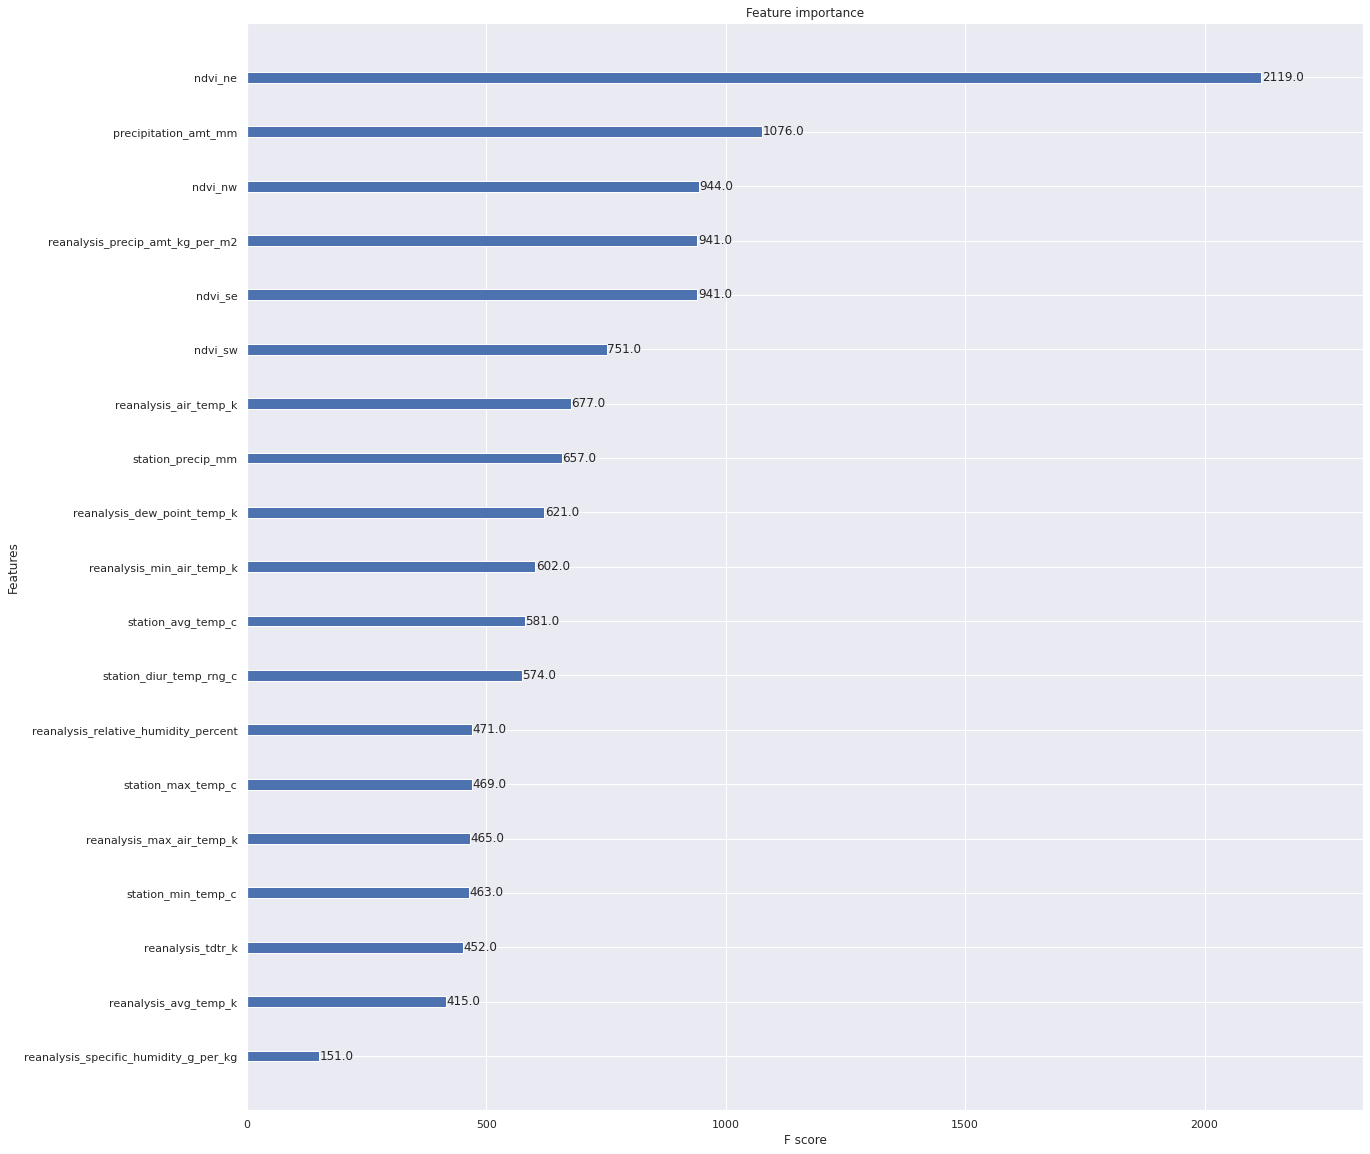

In [31]:
iqModel = train(iq_df_imputed, iqPart)

In [ ]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

## Predicting on the Test Dataset

In [32]:
testSJ = testDf[testDf.city == 'sj'].drop(unwantedCols, axis = 1, errors = 'ignore')
testIQ = testDf[testDf.city == 'iq'].drop(unwantedCols, axis = 1, errors = 'ignore')

SJPreds = testDf[testDf.city == 'sj'][['city', 'year', 'weekofyear']]
IQPreds = testDf[testDf.city == 'iq'][['city', 'year', 'weekofyear']]

def predict(df, outputFile, sjModel, iqModel):
    SJPreds['total_cases'] = sjModel.predict(testSJ).astype(int)
    IQPreds['total_cases'] = iqModel.predict(testIQ).astype(int)

    concatenated = pd.concat((SJPreds, IQPreds))
    concatenated.to_csv(f'{path}/Predictions/{outputFile}.csv', index=False)

AttributeError: 'DataFrame' object has no attribute 'city'